In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from joblib import dump
from keras.utils.vis_utils import plot_model
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, f1_score, make_scorer)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, Normalizer,
                                   OneHotEncoder, PowerTransformer,
                                   RobustScaler, StandardScaler)
from xgboost import XGBClassifier

from utils.GPU_models import (KerasClassifierModel, gpu_model_hub,
                              multi_input_embedded_model)
from utils.preprocessing_utils import (clean_labs, clean_notas,
                                       clean_sociodemograficos, merge_classes,
                                       merge_labs_notas,
                                       word_count_feat_engineering)


In [ ]:
set_config(display="diagram")
sns.set_style("darkgrid")
as_dual_class=False
target_feature = 'Código'
text_feature = 'Plan'
consolidate_classes = False

# False, 'oversample', or 'undersample'
balance_classes = 'oversample'

## Data setup

In [ ]:
df_notas = pd.read_csv('../data/notas.csv', sep=';')
df_laboratorios = pd.read_csv('../data/laboratorios.csv', sep=';')
df_sociodemografico = pd.read_csv('../data/sociodemografico.csv', sep=';')

In [ ]:
df_notas.head()

In [ ]:
df_laboratorios.head()

In [ ]:
df_sociodemografico.head()

In [ ]:
df_notas.head()

## Data Cleaning

In [ ]:
df_sociodemografico = clean_sociodemograficos(df_sociodemografico)
df_laboratorios = clean_labs(df_laboratorios)
df_notas = clean_notas(df_notas)

### Merge the sociodemographic data with the medical notes dataset

In [ ]:
df_merge = df_sociodemografico.merge(df_notas, how='inner', on='IDRecord')
df_merge

## Feature Engineering

In [ ]:
# Merge the classes
if consolidate_classes:
    df_merge = merge_classes(df_merge)

# Perform word count feature engineering
df_merge = word_count_feat_engineering(df_merge)

# Preprocess the lab data and merge it with the sociodemographic data
df_merge = merge_labs_notas(df_laboratorios, df_merge)

with pd.option_context('display.max_columns', None):
    display(df_merge.head(5))

## Label encoding

In [ ]:
X = df_merge.drop(labels=[target_feature], axis=1)
y = df_merge[target_feature]
if as_dual_class:
    y = y.str[:2]

label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)

np.unique(y_labels, return_counts=True)

## Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, train_size=0.2, random_state=42, stratify=y_labels)

## Class Balancing

In [ ]:
if balance_classes == 'oversample':
    # Using a naive oversampling approach
    sampler = RandomOverSampler(random_state=42)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
elif balance_classes == 'undersample':
    # Using a naive oversampling approach
    sampler = RandomOverSampler(random_state=42)
    X_train, y_train = sampler.fit_resample(X_train, y_train)

## Hyperparameter Setup

In [ ]:
numerical_features = list(set(['Edad', 'top_lab_avg_value', 'top_lab_count', 'total_lab_count'] + list(df_merge.drop(columns='IDRecord').select_dtypes(include='int64').columns)))
categorical_features = ['Genero', 'GrupoEtnico', 'AreaResidencial', 'EstadoCivil', 'TSangre', 'Tipo', 'top_lab_name']

In [ ]:
base_estimator = XGBClassifier()

numeric_preprocessor = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(missing_values=np.nan, strategy="mean"),
        ),
        ("scaler", StandardScaler()),
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(fill_value="missing", strategy="constant"),
        ),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

text_preprocessor = Pipeline(
    steps=[
        (
            "vectorizer",
            CountVectorizer(
                strip_accents="unicode",
                stop_words=nltk.corpus.stopwords.words("spanish"),
            ),
        ),
        ("tfidf", TfidfTransformer()),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, categorical_features),
        ("numerical", numeric_preprocessor, numerical_features),
        # ("text", text_preprocessor, text_features),
    ]
)

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("estimator", base_estimator),
    ]
)

## Hyperparameter tuning

In [ ]:
param_grid = {
    "preprocessor__numerical__imputer": [
        SimpleImputer(missing_values=np.nan, strategy="mean"),
        SimpleImputer(missing_values=np.nan, strategy="median"),
        SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        KNNImputer(),
    ],
    "preprocessor__numerical__scaler": [
        StandardScaler(),
        RobustScaler(),
        MinMaxScaler(),
        Normalizer(),
        # PowerTransformer(),
    ],
}

In [ ]:
scoring = {
    "Accuracy": "balanced_accuracy",
    "Weighted_F1": make_scorer(f1_score, average='weighted'),
    # 'roc_auc':make_scorer(roc_auc_score, average='weighted'),
    }

hyperparam_tuner = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=8,
    cv=3,
    n_jobs=-2,
    scoring=scoring,
    refit='Weighted_F1',
    verbose = 2,
    random_state=42,
)

hyperparam_tuner.fit(X_train, y_train)
cv_results = pd.DataFrame(hyperparam_tuner.cv_results_)

best_estimator = hyperparam_tuner.best_estimator_
preprocessor = best_estimator.named_steps['preprocessor']
preprocessor

In [ ]:
with pd.option_context('display.max_columns', None):
    display(cv_results.sort_values(by=["rank_test_Weighted_F1"]).head(30))

In [ ]:
X_train_preprocessed = pd.DataFrame.sparse.from_spmatrix(preprocessor.transform(X_train), columns=list(preprocessor.get_feature_names_out()))
X_test_preprocessed = pd.DataFrame.sparse.from_spmatrix(preprocessor.transform(X_test), columns=list(preprocessor.get_feature_names_out()))

In [ ]:
# embedding = "nnlm-es-dim128"
embedding = "nnlm-es-dim128-with-normalization"
# embedding = "https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-24_H-1024_A-16/1"


model_function = multi_input_embedded_model
clf = KerasClassifierModel(
    build_fn=model_function,
    class_number=len(np.unique(y_train)),
    feature_number=len(X_train_preprocessed.columns),
    embedding = embedding,
    activation='relu',
    epochs=1000,
    batch_size=200,
    verbose=10,
)
model = model_function(
    class_number=len(np.unique(y_train)),
    feature_number=len(X_train_preprocessed.columns),
    embedding = embedding,
    ).summary()

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

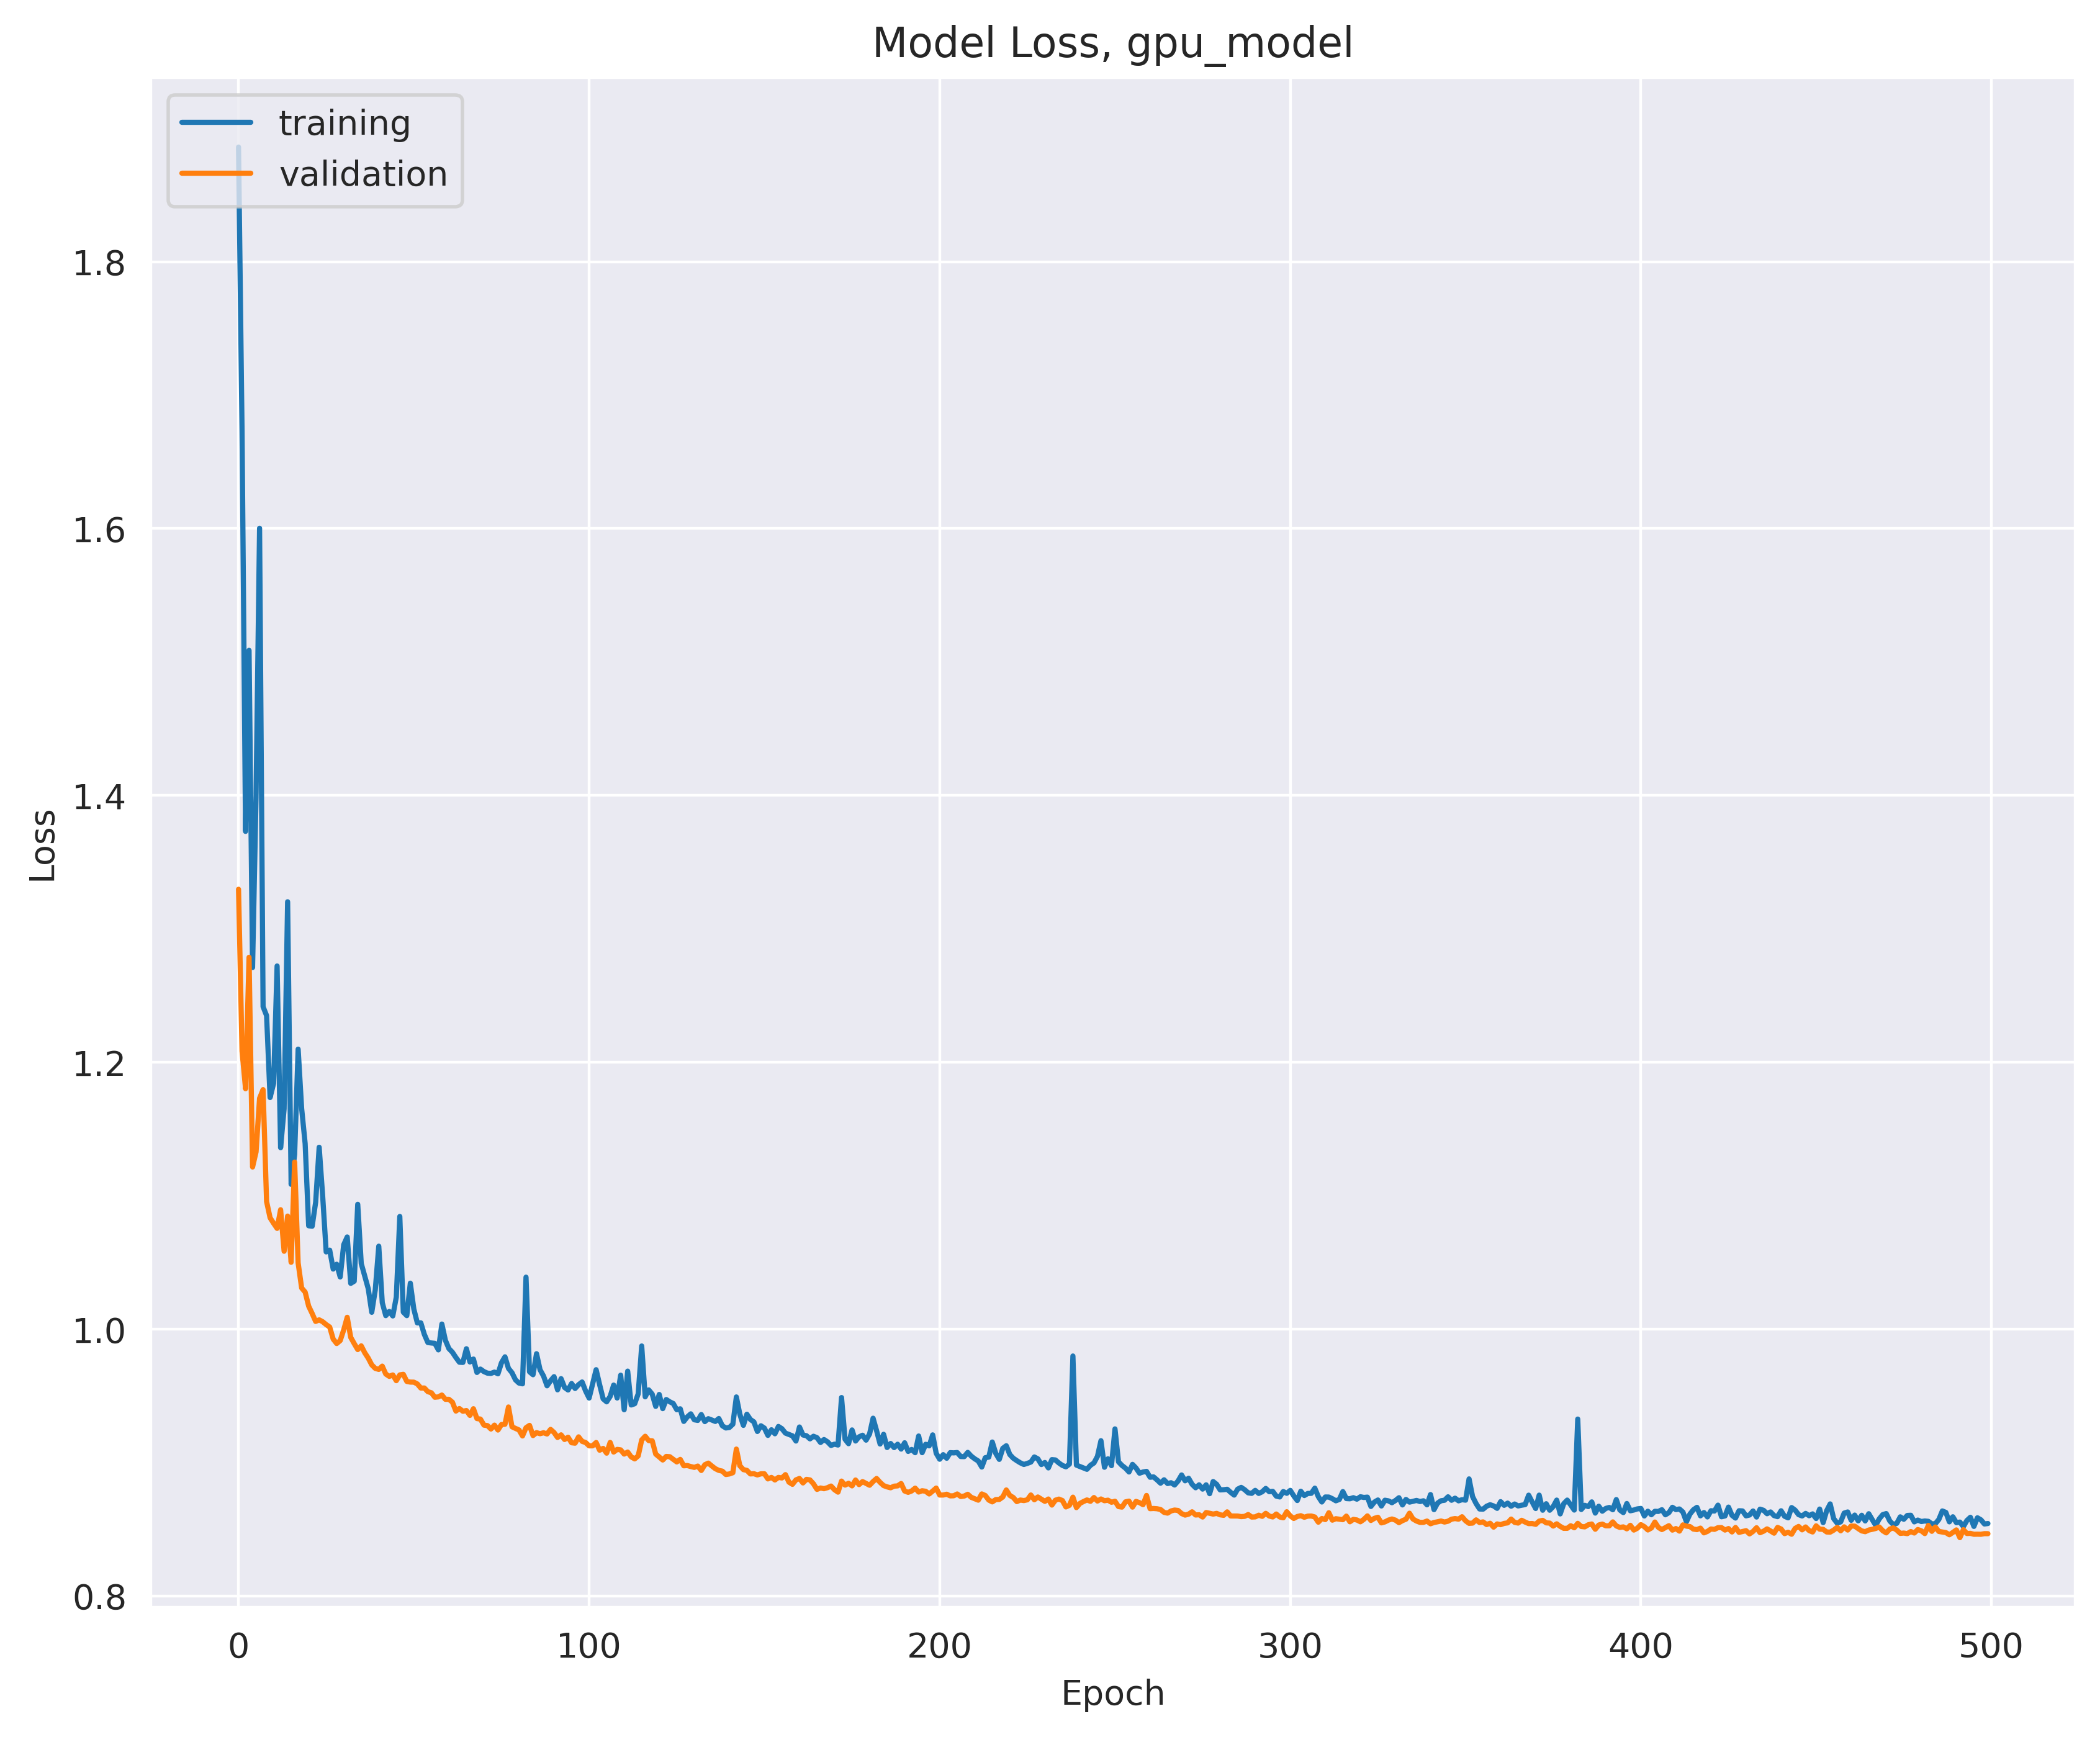

<Figure size 640x480 with 0 Axes>

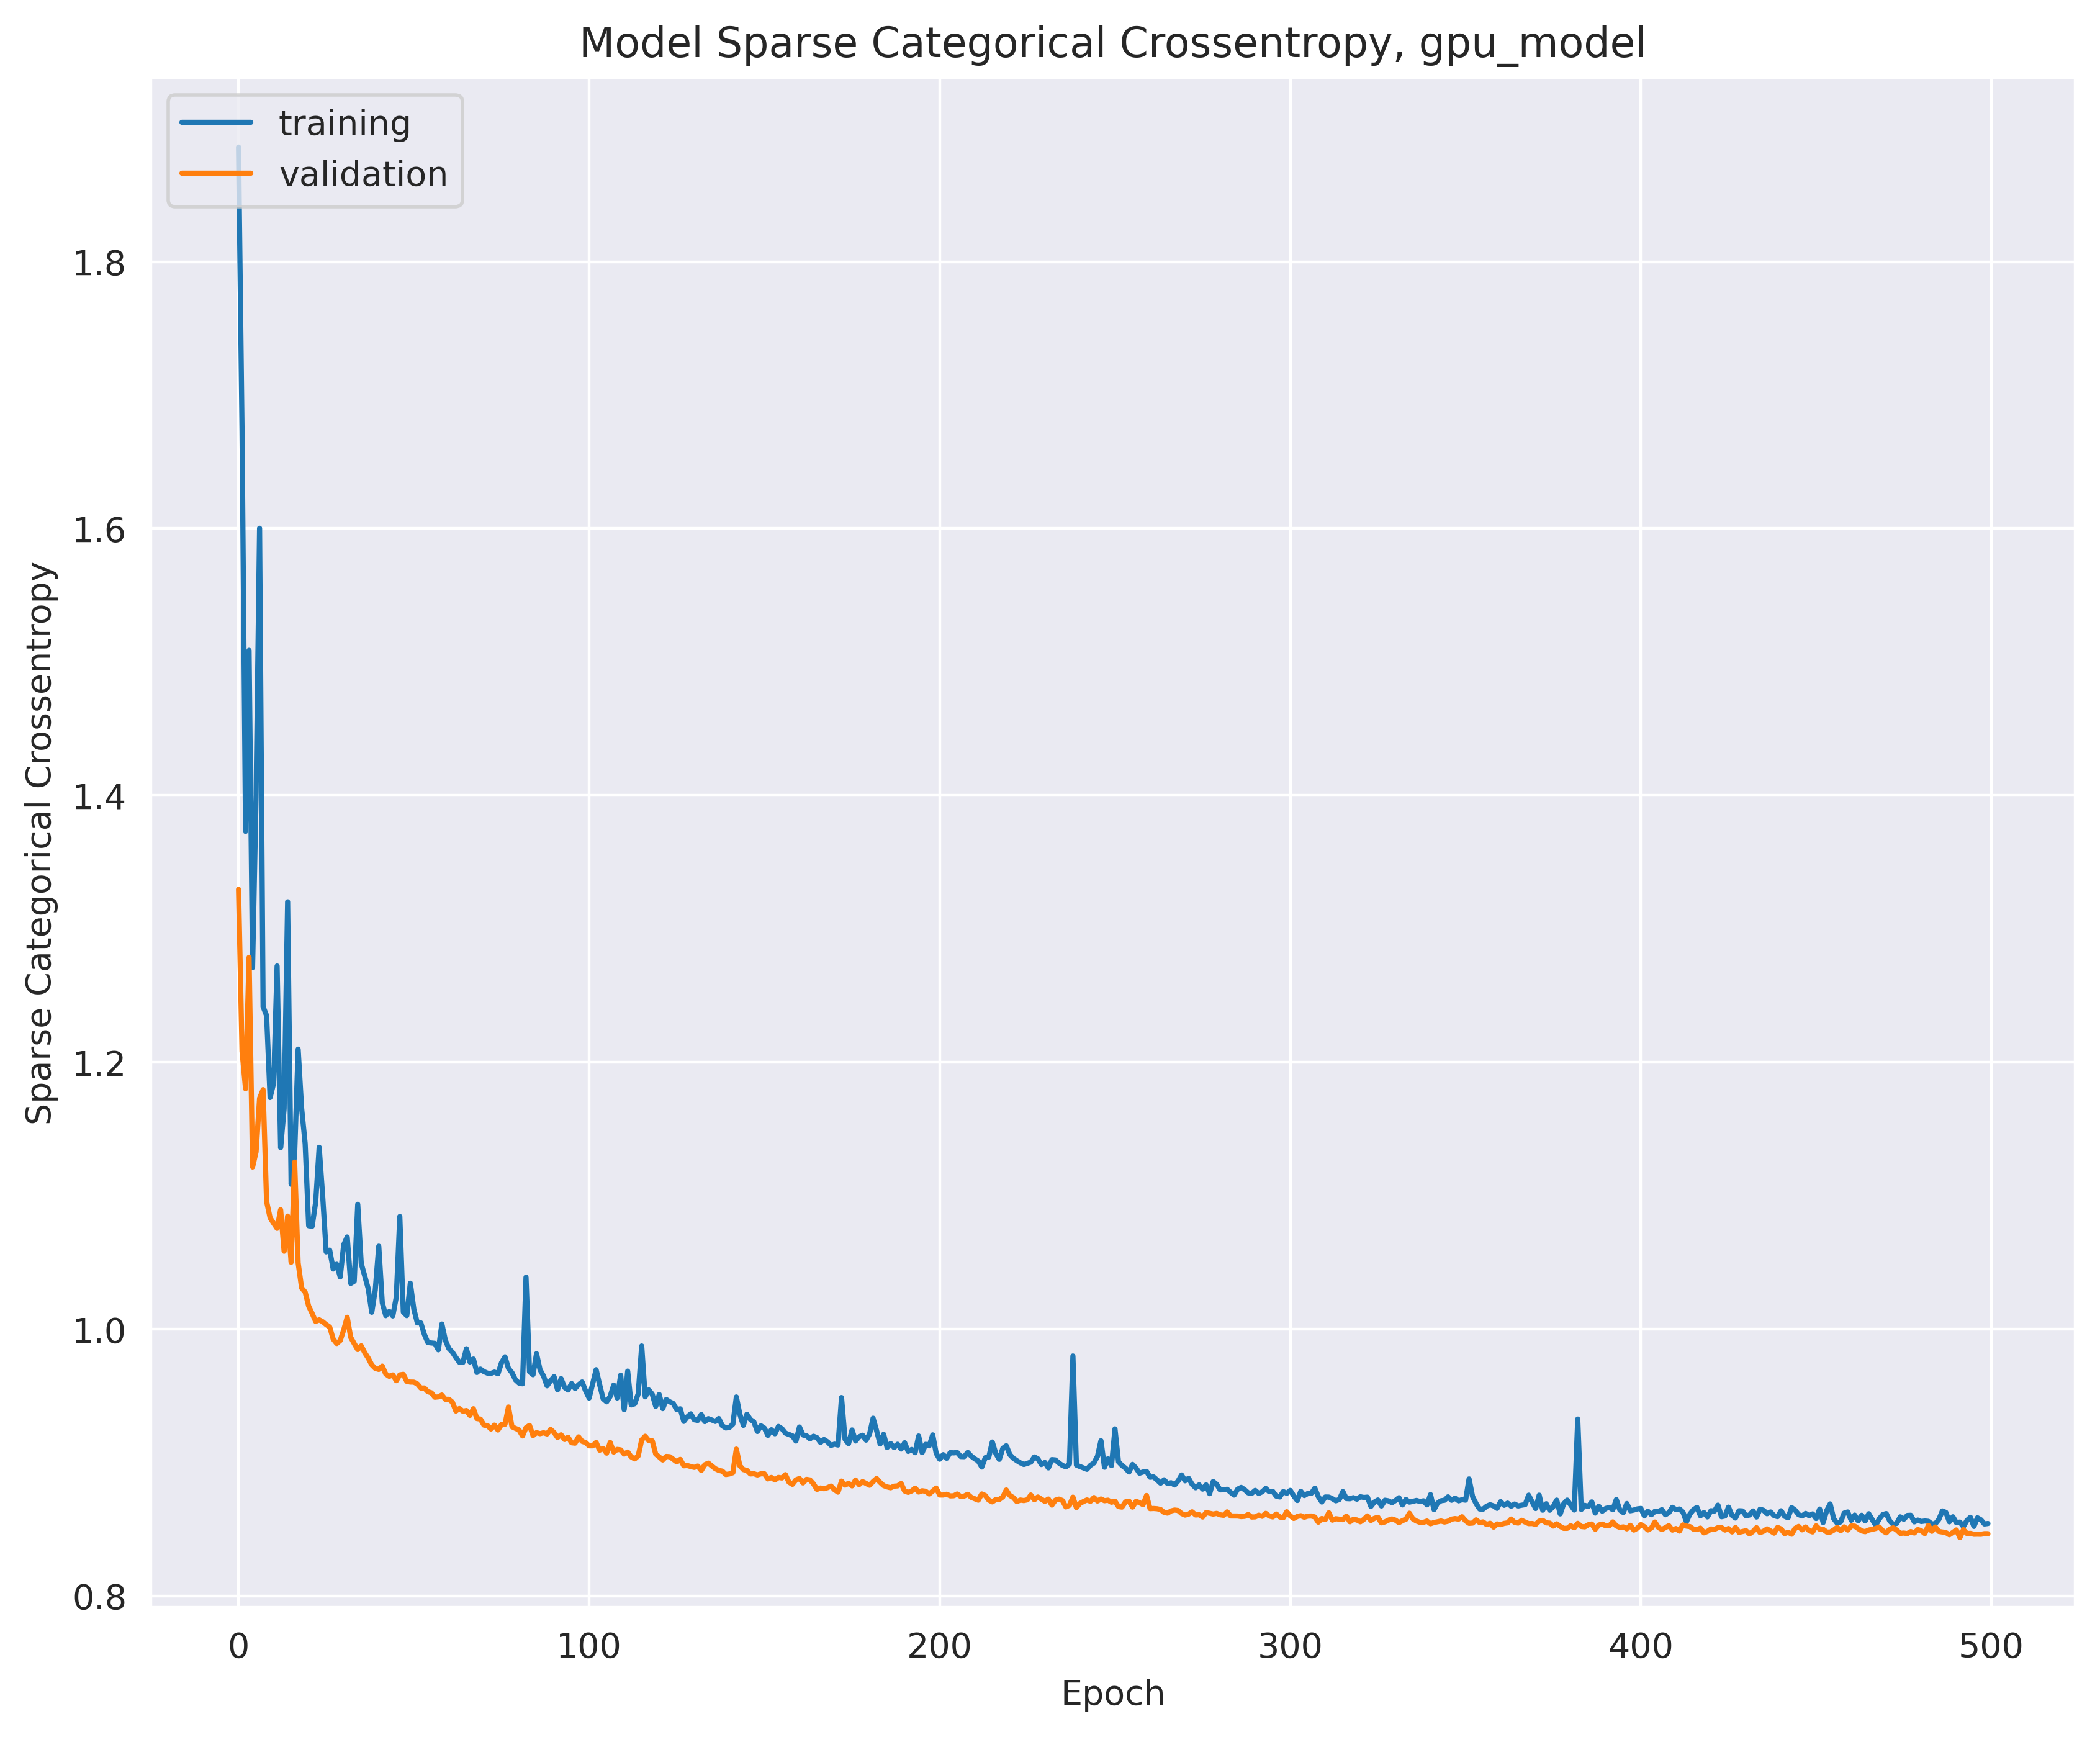

<Figure size 640x480 with 0 Axes>

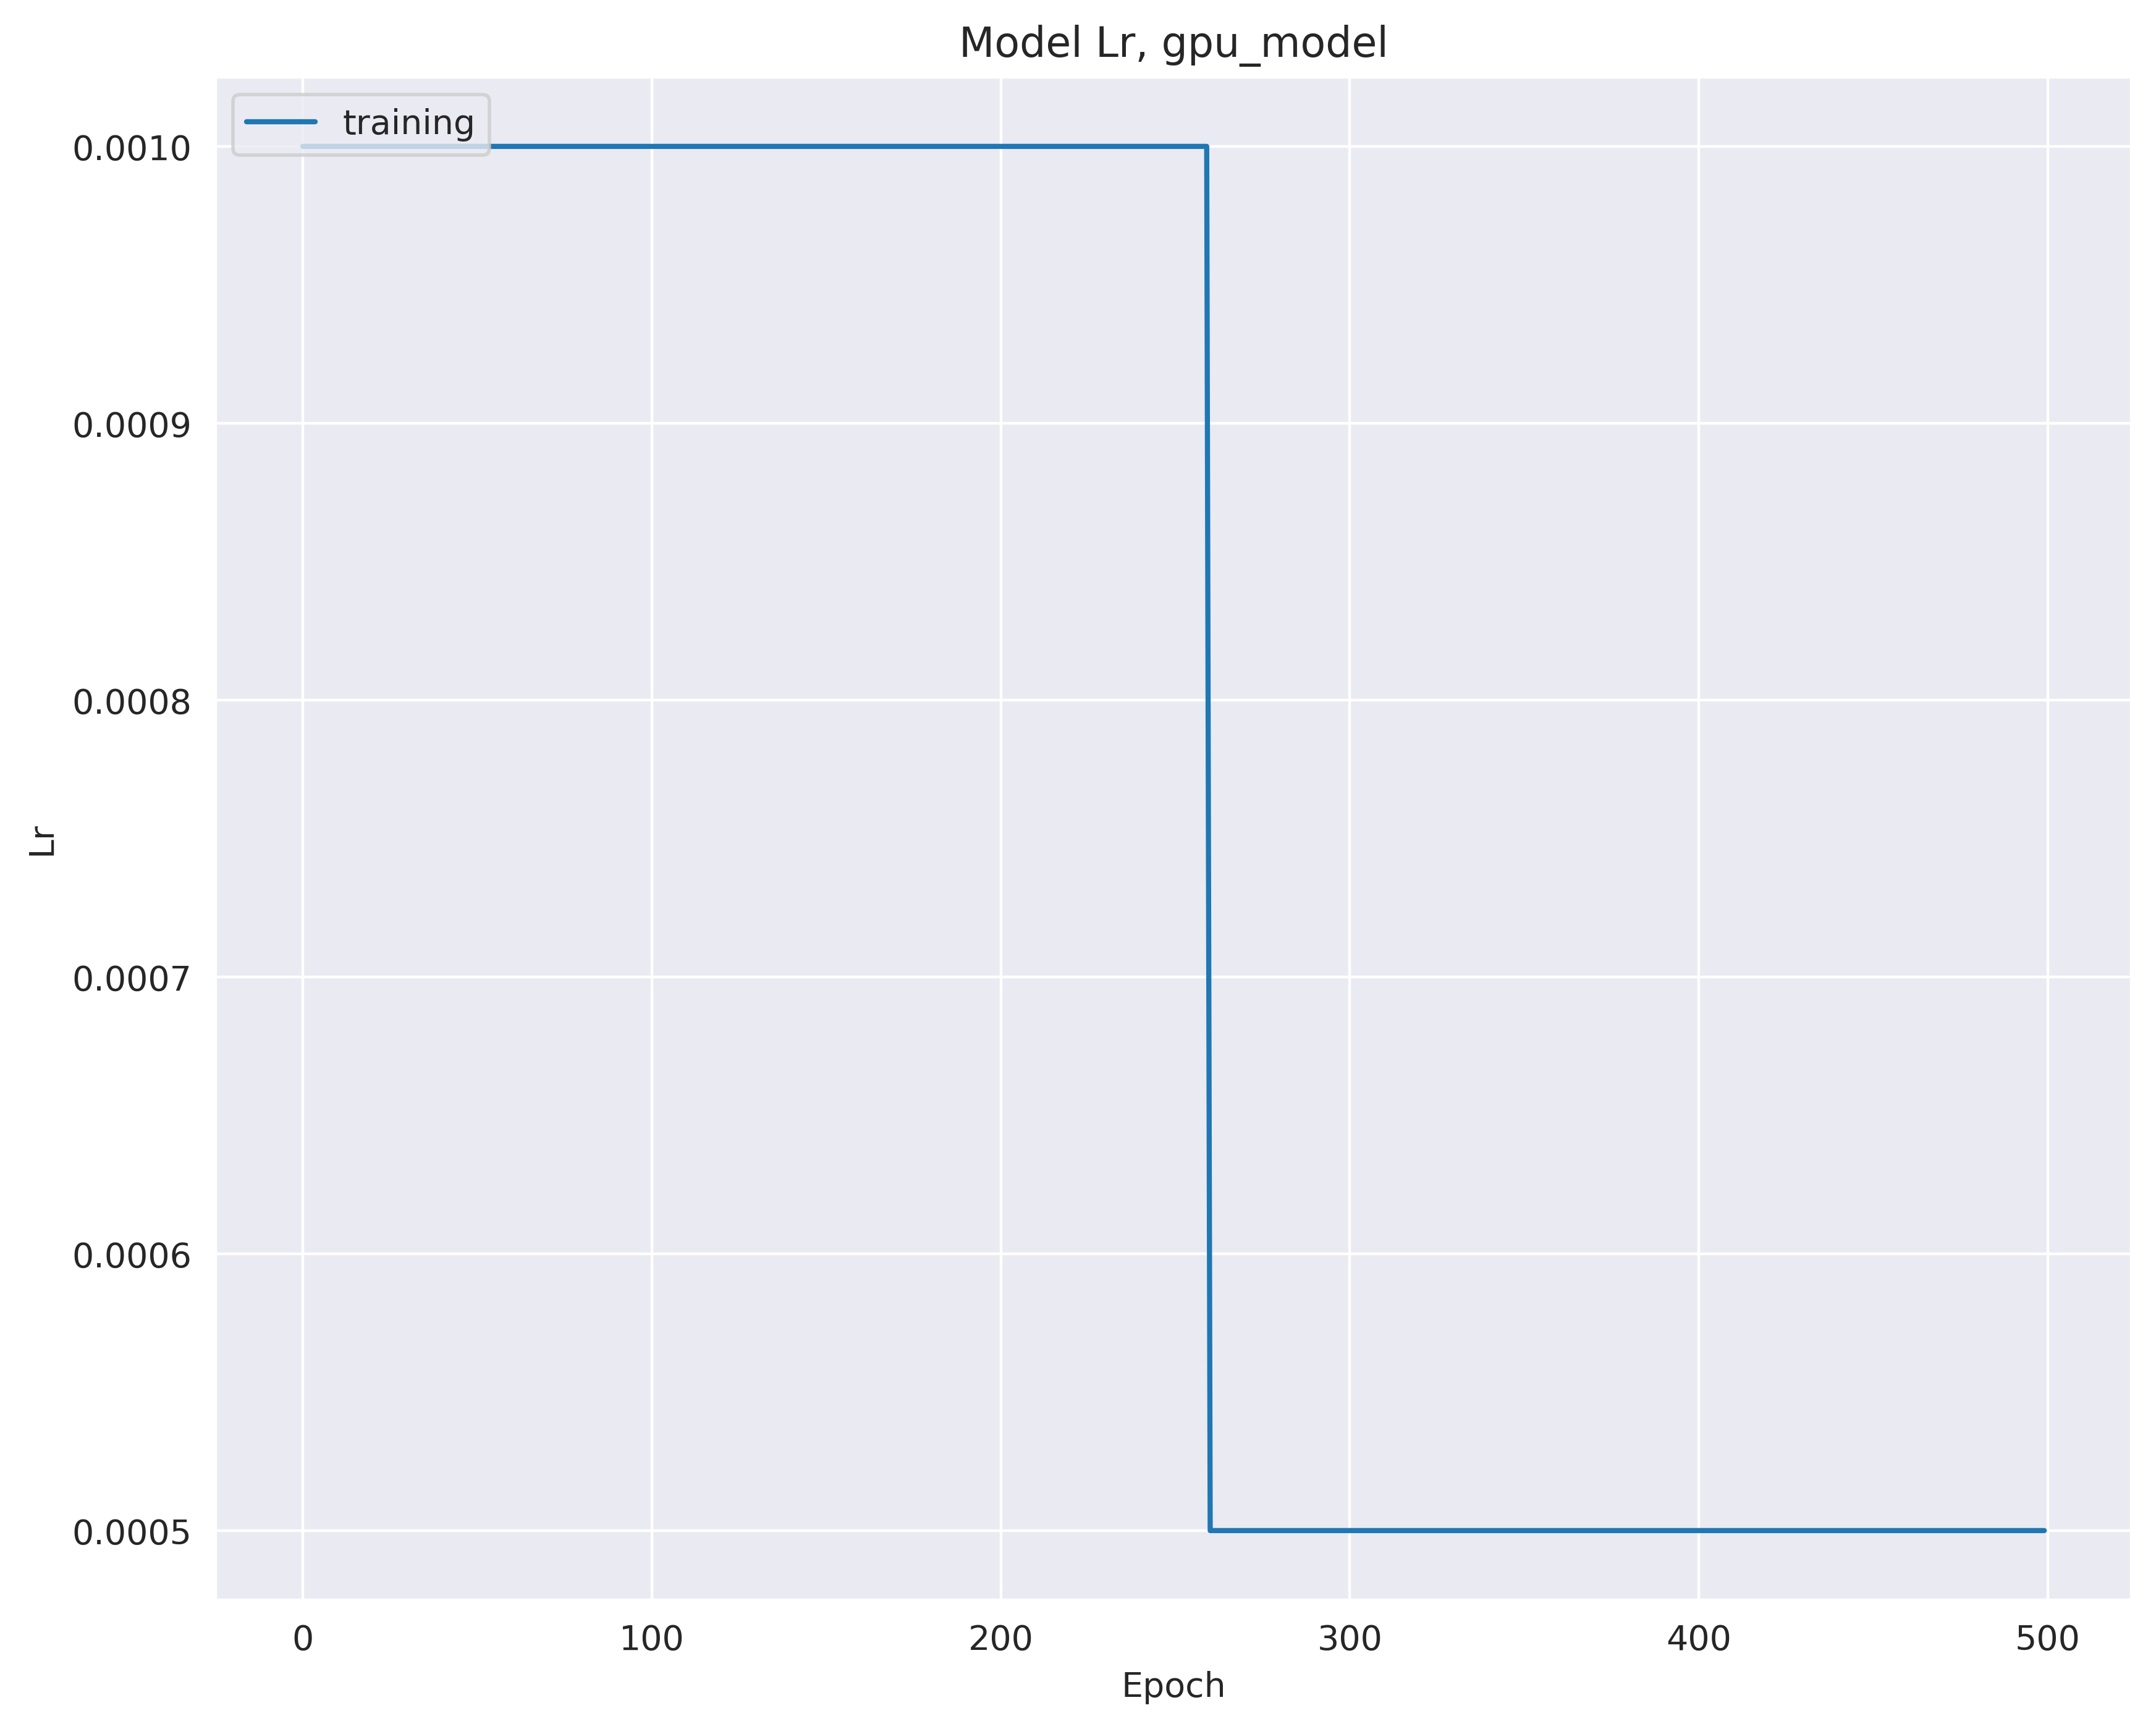

In [21]:
hist = clf.fit([X_train_preprocessed, X_train[text_feature]], y_train)
clf.plot_learning_curves('data/output/gpu_model')

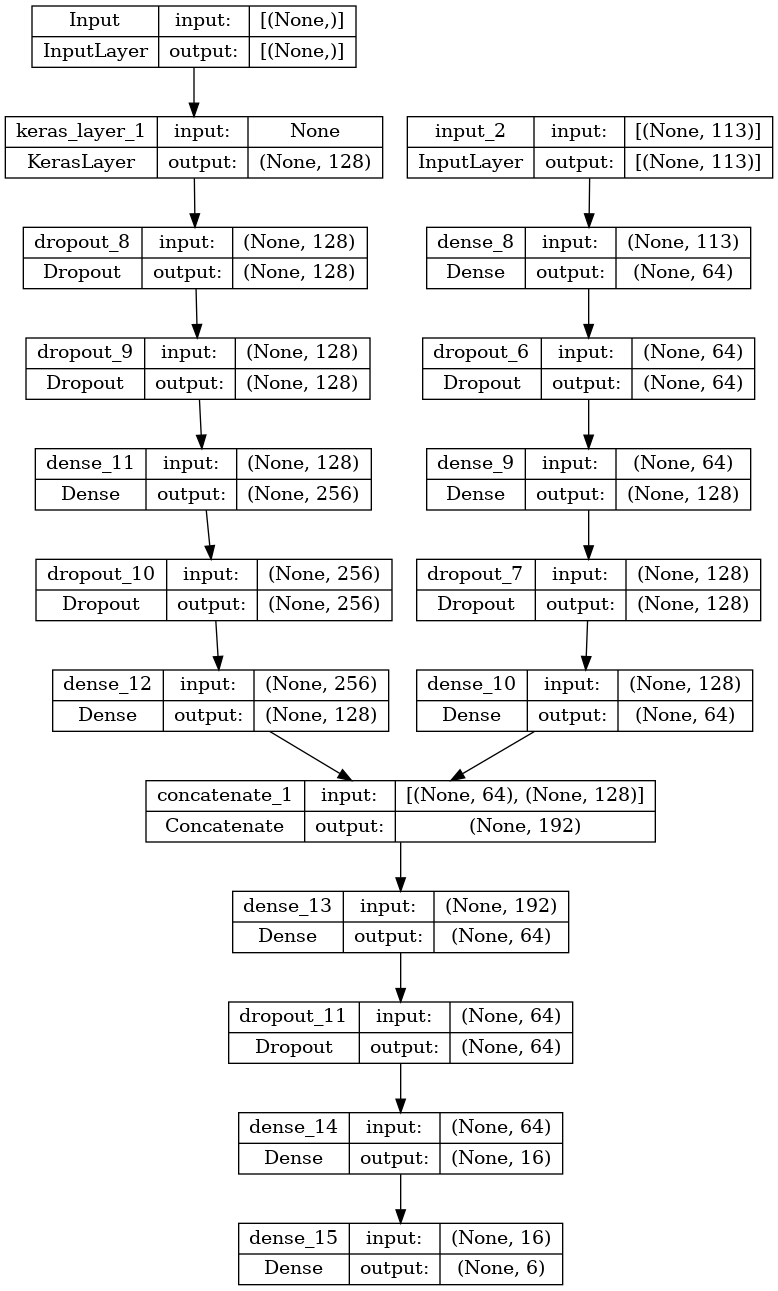

In [27]:
model_plot_savepath = Path('data') / 'output' / 'gpu_model' / 'model_plot.png'
model_plot_savepath.parent.mkdir(parents=True, exist_ok=True)
plot_model(clf.model, to_file=str(model_plot_savepath), show_shapes=True, show_layer_names=True)
# clf.model

## Scoring

In [28]:
labels_decoded = label_encoder.inverse_transform(np.unique(y_train))
y_pred = clf.predict([X_test_preprocessed, X_test[text_feature]])

3505/3505 [==============================] - 29s 8ms/step


In [29]:
display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, labels=np.unique(y_train), target_names=labels_decoded, zero_division=False)).transpose().round(2))

,precision,recall,f1-score,support
A51,0.00,0.00,0.00,2948.00
A530,0.65,0.87,0.75,48469.00
A539,0.80,0.55,0.65,39503.00
E109,0.00,0.00,0.00,5022.00
E119,0.57,0.80,0.67,13950.00
E149,0.00,0.00,0.00,2246.00
accuracy,0.67,0.67,0.67,0.67
macro avg,0.34,0.37,0.34,112138.00
weighted avg,0.63,0.67,0.63,112138.00


<Figure size 640x480 with 0 Axes>

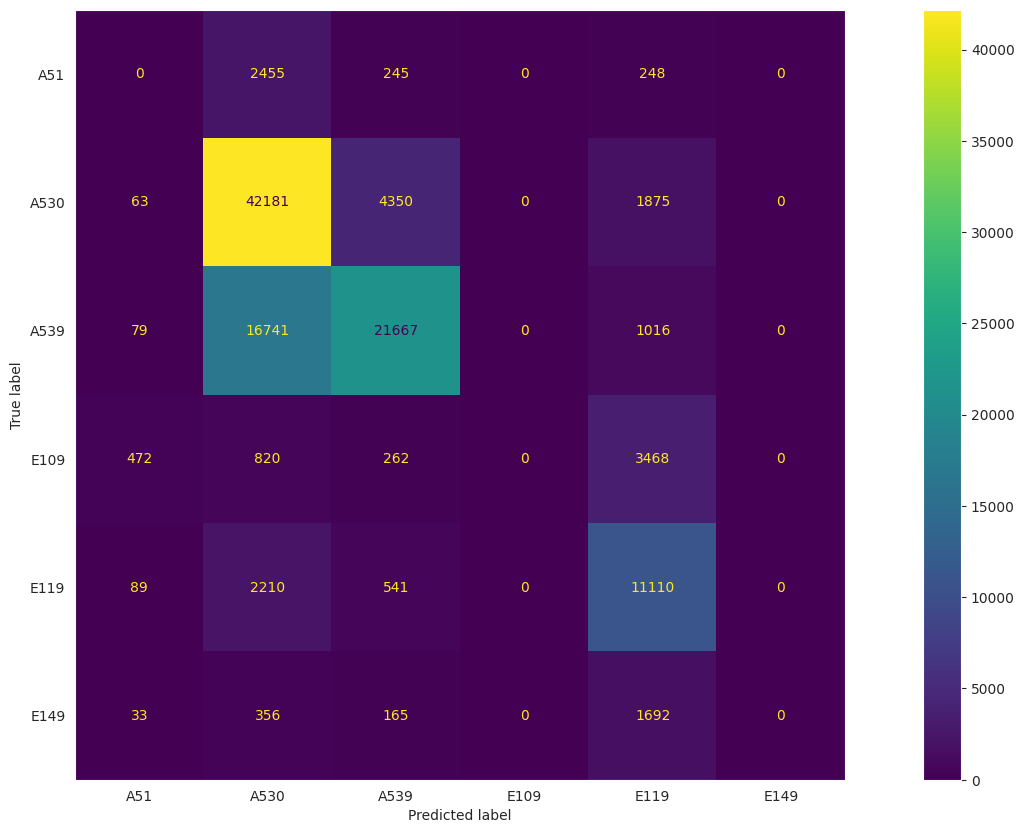

In [30]:
test_confusion_matrix = confusion_matrix(y_test, y_pred)

with sns.axes_style("dark"):
    fig, ax = plt.subplots(figsize=(20,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix,
                                display_labels=labels_decoded)
    disp.plot(ax=ax, cmap='viridis')
    plt.show()

## Saving the best performing model

In [ ]:
save_path = Path('data') / 'output' / 'best_model.pickle'
save_path.parent.mkdir(parents=True, exist_ok=True)
dump(best_model, str(save_path))
dump(score, str(save_path.parent / f'best_model_score{save_path.suffix}'))